In [1]:
#pca
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
train_files = os.listdir('train_40_csv')
test_files = os.listdir('test_10_csv')
print(train_files.__len__())
print(test_files.__len__())

40
10


In [3]:
# take a look at the 1 file in the train set and the 1 file in the test set
train = pd.read_csv('train_40_csv/' + train_files[0])
test = pd.read_csv('test_10_csv/' + test_files[0])
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7499 entries, 0 to 7498
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fea1    7499 non-null   float64
 1   fea2    7499 non-null   float64
 2   fea3    7499 non-null   float64
 3   fea4    7499 non-null   float64
 4   ans     7499 non-null   float64
dtypes: float64(5)
memory usage: 293.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7499 entries, 0 to 7498
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fea1    7499 non-null   float64
 1   fea2    7499 non-null   float64
 2   fea3    7499 non-null   float64
 3   fea4    7499 non-null   float64
 4   ans     7499 non-null   float64
dtypes: float64(5)
memory usage: 293.1 KB
None


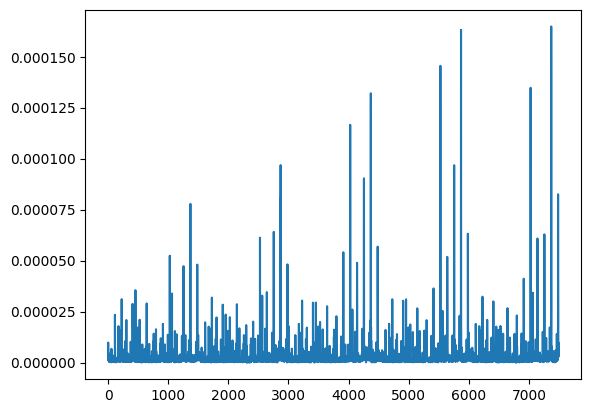

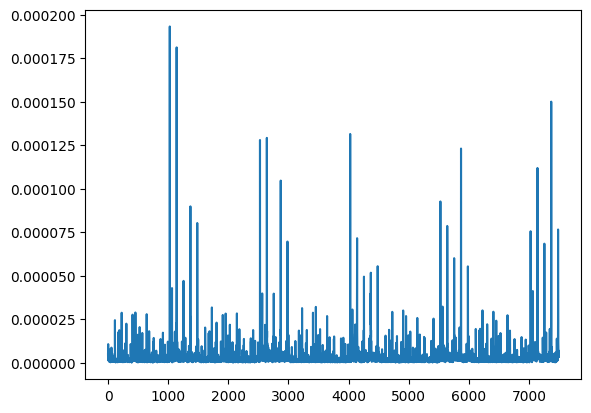

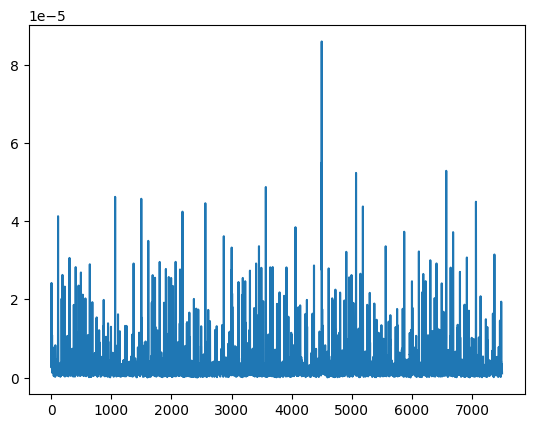

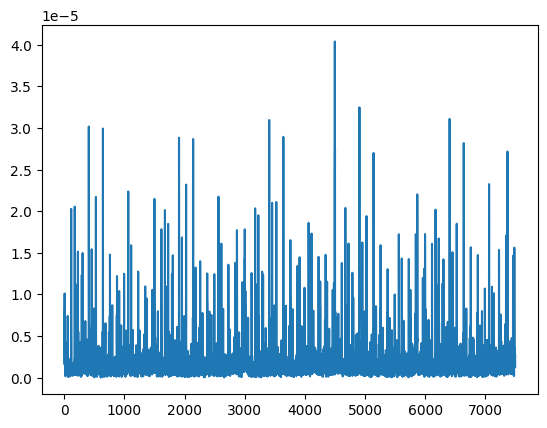

In [4]:
# plot the all col except the ans
for i in range(0,4):
    plt.plot(train.iloc[:,i])
    plt.show()

In [5]:
# load all the data
train_data = []
test_data = []
for file in train_files:
    train_data.append(pd.read_csv('train_40_csv/' + file))
for file in test_files:
    test_data.append(pd.read_csv('test_10_csv/' + file))

# convert the data to numpy array
train_data_np = []
test_data_np = []

for data in train_data:
    train_data_np.append(data.to_numpy())
for data in test_data:
    test_data_np.append(data.to_numpy())

train_data_np = np.array(train_data_np)
test_data_np = np.array(test_data_np)

print(train_data_np.shape)
print(test_data_np.shape)

(40, 7499, 5)
(10, 7499, 5)


In [6]:
# pca per col
pcas = []
train_data_pca = []
test_data_pca = []
components = 32
for i in range(0,4):
    pca = PCA(n_components=components)
    pca.fit(train_data_np[:,:,i])
    pcas.append(pca)
    # show the total explained variance
    print(np.sum(pca.explained_variance_ratio_))

    train_data_pca.append(pca.transform(train_data_np[:,:,i]))
    test_data_pca.append(pca.transform(test_data_np[:,:,i]))

train_data_pca = np.array(train_data_pca).reshape(40,components*4)
test_data_pca = np.array(test_data_pca).reshape(10,components*4)

print(train_data_pca.shape)
print(test_data_pca.shape)

0.988852446879838
0.9932329479803462
0.9796454309451901
0.9648093967088703
(40, 128)
(10, 128)


In [7]:
# append statistics from pd as more features
train_stats = []
test_stats = []
for data in train_data:
    train_stats.append(data.describe().to_numpy().flatten())
for data in test_data:
    test_stats.append(data.describe().to_numpy().flatten())

train_stats = np.array(train_stats)
test_stats = np.array(test_stats)

print(train_stats.shape)
print(test_stats.shape)

train_data_pca = np.concatenate((train_data_pca, train_stats), axis=1)
test_data_pca = np.concatenate((test_data_pca, test_stats), axis=1)

print(train_data_pca.shape)
print(test_data_pca.shape)

(40, 40)
(10, 40)
(40, 168)
(10, 168)


In [8]:
# ans is the last col
train_ans = train_data_np[:,0,-1]
test_ans = test_data_np[:,0,-1]
print(train_ans.shape)
print(test_ans.shape)

(40,)
(10,)


In [9]:
from xgboost import XGBRegressor
# data split
from sklearn.model_selection import train_test_split

# cv
from sklearn.model_selection import cross_val_score

In [10]:
# split the data
X_train, X_val, y_train, y_val = train_test_split(train_data_pca, train_ans, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(32, 168)
(8, 168)
(32,)
(8,)


In [11]:
# cv
model = XGBRegressor()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print(f'cv mse: {scores.mean()}')
#rmse
print(f'cv rmse: {np.sqrt(-scores.mean())}')

# fit the model
model.fit(X_train, y_train)
# predict
y_pred = model.predict(X_val)
# is diff less than 1% of the ans is correct
print(np.sum(np.abs(y_pred - y_val) < y_val*0.01)/y_val.shape[0])


cv mse: -0.012311614643512261
cv rmse: 0.11095771556549036
0.125


In [12]:
# svr
from sklearn.svm import SVR
model = SVR()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print(f'cv mse: {-scores.mean()}')
#rmse
print(f'cv rmse: {np.sqrt(-scores.mean())}')

# fit the model
model.fit(X_train, y_train)
# predict
y_pred = model.predict(X_val)
# is diff less than 1% of the ans is correct
print(np.sum(np.abs(y_pred - y_val) < y_val*0.01)/y_val.shape[0])


cv mse: 0.046963354710068905
cv rmse: 0.2167103013473723
0.0


In [13]:
import optuna


c:\Users\ricky\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
def objective(trial):
    # params
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1500),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'objective': 'reg:squarederror'
    }
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(np.mean((y_pred - y_val)**2))
    correct = np.sum(np.abs(y_pred - y_val) < y_val*0.01)/y_val.shape[0]
    return correct-rmse

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2025-03-08 23:14:00,863] A new study created in memory with name: no-name-e83ee79b-dc4c-440c-aa0e-10e27405679d
[I 2025-03-08 23:14:01,035] Trial 0 finished with value: -0.19865291330349524 and parameters: {'n_estimators': 802, 'max_depth': 3, 'learning_rate': 0.048471086819347795, 'subsample': 0.4982162990147009, 'colsample_bytree': 0.9000256640491536, 'gamma': 6.328928048304132, 'reg_alpha': 6.710346184431754, 'reg_lambda': 8.572062006054766}. Best is trial 0 with value: -0.19865291330349524.
[I 2025-03-08 23:14:01,229] Trial 1 finished with value: -0.20019283987031716 and parameters: {'n_estimators': 752, 'max_depth': 12, 'learning_rate': 0.1413380153787499, 'subsample': 0.557368643884853, 'colsample_bytree': 0.14613512133308307, 'gamma': 8.828543195651257, 'reg_alpha': 1.5912691156154124, 'reg_lambda': 6.175635214320297}. Best is trial 0 with value: -0.19865291330349524.
[I 2025-03-08 23:14:01,462] Trial 2 finished with value: -0.19898126326037713 and parameters: {'n_estimators':

In [32]:
print(study.best_params)
print(study.best_value)

{'n_estimators': 802, 'max_depth': 3, 'learning_rate': 0.048471086819347795, 'subsample': 0.4982162990147009, 'colsample_bytree': 0.9000256640491536, 'gamma': 6.328928048304132, 'reg_alpha': 6.710346184431754, 'reg_lambda': 8.572062006054766}
-0.19865291330349524


In [16]:
# svr
def objective(trial):
    # params
    params = {
        'C': trial.suggest_float('C', 0.0001, 10000),
        'epsilon': trial.suggest_float('epsilon', 0.0001, 10),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 0.0001, 10),


    }
    model = SVR(**params)
    model.fit(X_train, y_train)
    correct = np.sum(np.abs(model.predict(X_val) - y_val) < y_val*0.01)/y_val.shape[0]
    rmse = np.sqrt(np.mean((model.predict(X_val) - y_val)**2))
    return correct - rmse

study = optuna.create_study(direction='maximize')
# with timeout
study.optimize(objective, n_trials=1000,gc_after_trial=True)


[I 2025-03-08 23:33:22,028] A new study created in memory with name: no-name-90be56a6-0ed7-49bc-adae-f63c2633bbcd
[I 2025-03-08 23:33:22,030] Trial 0 finished with value: -0.18358670294985968 and parameters: {'C': 1932.3170354193983, 'epsilon': 8.399254756788737, 'degree': 5, 'gamma': 5.438593104643912}. Best is trial 0 with value: -0.18358670294985968.
[I 2025-03-08 23:33:22,093] Trial 1 finished with value: -0.18358670294985968 and parameters: {'C': 8948.332840469928, 'epsilon': 8.360124942599953, 'degree': 3, 'gamma': 8.783136354148072}. Best is trial 0 with value: -0.18358670294985968.
[I 2025-03-08 23:33:22,153] Trial 2 finished with value: -0.18358670294985968 and parameters: {'C': 229.5388424389226, 'epsilon': 7.762248503241478, 'degree': 1, 'gamma': 6.697133185778317}. Best is trial 0 with value: -0.18358670294985968.
[I 2025-03-08 23:33:22,218] Trial 3 finished with value: -0.18358670294985965 and parameters: {'C': 8109.345343268505, 'epsilon': 1.991630572902116, 'degree': 4, 

In [20]:
print(study.best_params)
print(study.best_value)
print(f'rmse: {1-study.best_value}')
print(f'mse: {(1-study.best_value)**2}')


{'C': 3448.7800403303095, 'epsilon': 0.00029277960636932276, 'degree': 1, 'gamma': 0.0012971827498011734}
0.9999015620070235
rmse: 9.843799297648559e-05
mse: 9.690038461238626e-09


0.0
